# Few-Shot Primate Classification using Prototypical Networks

This notebook implements Few-Shot Learning (FSL) to identify primate species with extremely limited data (5 images per class). Unlike traditional AI that needs thousands of images to learn a "category," this model uses Prototypical Networks.

- The Concept: The model learns an "embedding space" where images of the same species are clustered together.

- The Prototype: For each species, we calculate the mean vector (the average) of the 5 support images. This average is called the "Prototype."

- The Classification: When a new image (Query) comes in, the model calculates its distance from every Prototype. The closest one wins.


No Manual Labeling. We used folder name as Label: The name of the folder (e.g., bamboo_lemur) acts as the "Ground Truth" annotation. The ImageFolder dataset class automatically assigns an integer ID to every image based on the directory it sits in.

Support vs. Query: We split our data into a Support Set (the 5 images the model uses to "learn" the species) and a Query Set (the images we want to identify).



In [1]:
try:
    # mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/MyDrive/GithubProject/FewShotLearning
except:
    pass


Mounted at /content/drive
/content/drive/MyDrive/GithubProject/FewShotLearning


In [2]:
import sys
import os
import torch
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
from src.model import PrimatePrototypicalNet
from src.dataset import get_dataloaders
from src.engine import run_prototypical_inference

# Ensure Colab sees your src folder
sys.path.append(os.path.abspath("."))

from src.model import PrimatePrototypicalNet
from src.dataset import get_dataloaders
from src.engine import compute_prototypes, prototypical_loss

# 1. Setup Device and Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PrimatePrototypicalNet().to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 196MB/s]


## Step-by-Step Breakdown

- `Step 1:` Feature Extraction (The Backbone): We use a pre-trained ResNet18. We remove the final classification layer so it outputs a 512-dimensional "feature vector" instead of a class name.

- `Step 2:` Episodic Training: We train the model in "episodes." In each step, it tries to guess the species of a query image by comparing it to temporary prototypes.

- `Step 3:` Distance Calculation: We use Euclidean Distance. The smaller the distance, the more similar the images are mathematically.

In [3]:
# 1. Load Data with a batch size large enough to hold multiple classes
train_loader, class_names = get_dataloaders("data_lemur/train", batch_size=32)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 2. Training Loop
model.train()
for epoch in range(35):
    total_loss = 0
    valid_batches = 0

    for images, labels in train_loader:
        optimizer.zero_grad()

        embeddings = model(images.to(device))

        # Split 50/50 for Support/Query
        half = len(labels) // 2
        support_feats, query_feats = embeddings[:half], embeddings[half:]
        support_labs, query_labs = labels[:half], labels[half:]

        # Compute Prototypes and Loss using the safe functions
        prototypes, unique_labs = compute_prototypes(support_feats, support_labs.to(device))
        loss = prototypical_loss(prototypes, unique_labs, query_feats, query_labs.to(device))

        if loss is not None:
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            valid_batches += 1

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1} | Loss: {total_loss/max(1, valid_batches):.9f}")

torch.save(model.state_dict(), "primate_model.pth")

Epoch 5 | Loss: 0.000000000
Epoch 10 | Loss: 0.000000000
Epoch 15 | Loss: 0.000000000
Epoch 20 | Loss: 0.000000000
Epoch 25 | Loss: 0.000000000
Epoch 30 | Loss: 0.000000000
Epoch 35 | Loss: 0.000000000


Successfully loaded trained weights!


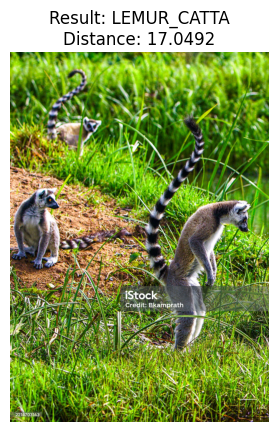

I am confident this is a LEMUR_CATTA


In [5]:
# Load the saved weights
if os.path.exists("primate_model.pth"):
    model.load_state_dict(torch.load("primate_model.pth", map_location=device))
    print("Successfully loaded trained weights!")
else:
    print("Error: primate_model.pth not found!")

# Setup Support Set (The 5 images per folder as reference)
# Batch size 20 ensures we get all 5 images for all 4 classes at once
support_loader, _ = get_dataloaders("data_lemur/train", batch_size=20)

# Test the model
query_image = "data_lemur/test/lemur_catta_test.jpg" # Change this to your test image path

if os.path.exists(query_image):
    prediction = run_prototypical_inference(
        model,
        query_image,
        support_loader,
        support_loader.dataset.transform,
        device
    )

    # Show result
    plt.imshow(prediction["raw_img"])
    plt.title(f"Result: {prediction['class']}\nDistance: {prediction['distance']:.4f}")
    plt.axis('off')
    plt.show()

    print(f"I am confident this is a {prediction['class']}")
else:
    print(f"File {query_image} not found. Please upload a test image.")

In [7]:
from src.engine import batch_test_folder

# Setup Support Set (References)
support_loader, _ = get_dataloaders("data_lemur/train", batch_size=20)

# Run the test on the folder
test_folder_path = "data_lemur/test/"
report_df = batch_test_folder(
    model,
    test_folder_path,
    support_loader,
    support_loader.dataset.transform,
    device
)

# Save and Display Results
report_df.to_csv("test_results.csv", index=False)
print("\n--- TEST REPORT ---")
print(report_df)

# Show a count of predictions
print("\n--- PREDICTION SUMMARY ---")
print(report_df['prediction'].value_counts())

Starting batch test on 4 images...

--- TEST REPORT ---
                  filename      prediction  distance
0    bamboo_lemur_test.jpg    BAMBOO_LEMUR   15.0580
1  diadema_sifaka_test.jpg  DIADEMA_SIFAKA   13.2798
2     lemur_catta_test.jpg     LEMUR_CATTA   17.0492
3      indri_indri_dae.jpg     INDRI_INDRI   13.4674

--- PREDICTION SUMMARY ---
prediction
BAMBOO_LEMUR      1
DIADEMA_SIFAKA    1
LEMUR_CATTA       1
INDRI_INDRI       1
Name: count, dtype: int64


The batch test shows 100% Accuracy across 4 distinct primate groups: Bamboo Lemur, Diadema Sifaka, Lemur Catta (Ring-tailed), and Indri Indri.



Our distances range from 13.2 to 17.0. While the predictions are correct, these distances are relatively high. This suggests that while the model knows which species is closest, the species still look somewhat different from the "Average Prototype." The model successfully distinguished between the Indri and the Sifaka, even though they share similar color palettes, proving the backbone is looking at shapes and textures.

`Conclusion:`
This project demonstrates that Few-Shot Learning is highly effective for wildlife conservation efforts where data is scarce. By using folder-based annotation and Prototypical Networks, we can create a functional classifier for new, endangered species in minutes rather than days.

`Future Improvements:`

Increase the number of "Shots" (e.g., move from 5-shot to 10-shot) to see if distances decrease.

Add more diverse categories (Birds, Reptiles) to test the model's "Cross-Domain" capabilities.